In [1]:
# Enter your API key for ChatGPT
# import os
# os.environ["OPENAI_API_KEY"] = "Enter your API key here."
# Or alternatively save your OPENAI key in a .env file and load it via dotenv
from dotenv import load_dotenv
load_dotenv()
import scllm as sl
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from langchain_openai import ChatOpenAI

In [2]:
openai_model = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.0, model=openai_model)

# Factor analysis

In this tutorial, we'll walk through how to load preprocessed Peripheral Blood Mononuclear Cells (PBMC) data and apply Principal Component Analysis (PCA) using scanpy. PCA is a dimensionality reduction technique that helps capture the most important variation in high-dimensional data, making it easier to visualize and analyze.

## PBMC dataset


This following code loads a preprocessed dataset of 3,000 PBMCs (Peripheral Blood Mononuclear Cells), a widely used scRNA-seq dataset. Then we apply PCA on the dataset, reducing the dimensionality to 20 principal components (PCs).

In [3]:
pbmc = sc.datasets.pbmc3k_processed()
sc.pp.pca(pbmc, n_comps=20)

Now, apply LLM-based annotation to identify biological themes in the principal components:

* `PCs`: Specifies Principal Components as the factors to annotate.
* `llm`: A language model (LLM) used to assign biological meaning to gene sets.
* `top_genes=40`: Uses the top 40 genes contributing most to each PC for annotation.
* `key_added ='pca_annotation'`: Stores the generated annotations in pbmc.uns['pca_annotation'].
* `num_samples=2`: Specifies the number of interpretations to generate per factor.

In [4]:
sl.tl.annotate_factor(
    pbmc, 
    'PCs', 
    llm, 
    top_genes=40, 
    key_added='pca_annotation', 
    num_samples=5
)

After running the function, you can check the stored annotations:

In [5]:
pbmc.uns['pca_annotation']['mapping']

{'0+': 'Monocyte/Macrophage',
 '0-': 'CD8+ T cell',
 '1+': 'Cytotoxic T cell',
 '1-': 'B cell',
 '10+': 'Natural Killer (NK) Cell',
 '10-': 'Natural Killer (NK) cell',
 '11+': 'Macrophage',
 '11-': 'Dendritic Cell',
 '12+': 'Plasma Cell',
 '12-': 'Photoreceptor cell',
 '13+': 'B cell',
 '13-': 'T follicular helper cell',
 '14+': 'B cell',
 '14-': 'Natural Killer (NK) cell',
 '15+': 'Natural Killer (NK) Cell',
 '15-': 'Cardiomyocyte',
 '16+': 'B cell',
 '16-': 'B cell',
 '17+': 'B cell',
 '17-': 'T cell',
 '18+': 'B cell',
 '18-': 'B cell',
 '19+': 'Immune Cell (likely a subtype such as T cell or B cell)',
 '19-': 'Natural Killer (NK) Cell',
 '2+': 'Platelet',
 '2-': 'B cell',
 '3+': 'B cell',
 '3-': 'T cell',
 '4+': 'Monocyte/Macrophage',
 '4-': 'Dendritic Cell',
 '5+': 'CD8+ T cell',
 '5-': 'Natural Killer (NK) Cell',
 '6+': 'Natural Killer (NK) cell',
 '6-': 'T helper 1 (Th1) cell',
 '7+': 'Dendritic Cell',
 '7-': 'Natural Killer (NK) cell',
 '8+': 'Dendritic Cell',
 '8-': 'Activated

We can obtain a quick overview about the potential meaning of each PC using a stripplot:

* `X_pca`: Uses PCA embeddings for visualization.
* `pca_annotation`: Maps the biological annotations (e.g., cell-type-specific processes) to the PCA factors.
* `ax=ax`: Plots on the predefined matplotlib axis.
* `size=0.4`: Adjusts the point size for better readability.
* `jitter=0.2`: Adds small random noise to prevent points from overlapping.
* `ax.set_xlim([-20, 30])`: Restricts the x-axis range for better visualization.

Each dot represents a principal component (PC).
* The y-axis (inferred from pca_annotation) shows each factor and the biological themes assigned to their corresponding PCs.
* The x-axis represents the PCA factors for each cell in the dataset.

(-20.0, 30.0)

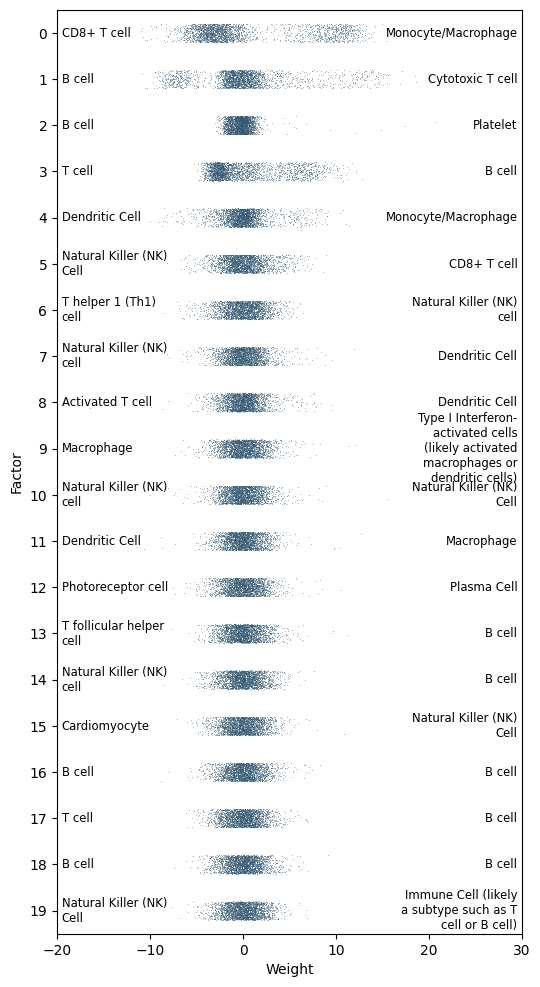

In [6]:
plt.figure(figsize=(6, 12))
ax = plt.gca()
sl.pl.factor_stripplot(
    pbmc,
    'X_pca',
    'pca_annotation',
    ax=ax,
    size=.4,
    jitter=.2
)
ax.set_xlim([-20, 30])

Next we visualize PCA factor contributions on a UMAP embedding using `sl.pl.factor_embedding`. This helps us understand how different principal components (PCs) relate to the low-dimensional structure of our single-cell RNA-seq data.

Why Is This Useful?
* PCA reduces dimensionality, identifying major sources of variation.
* UMAP preserves local and global structures, revealing meaningful biological clusters.
* Overlaying PCA factors on UMAP allows us to see which PCs influence different cell populations.

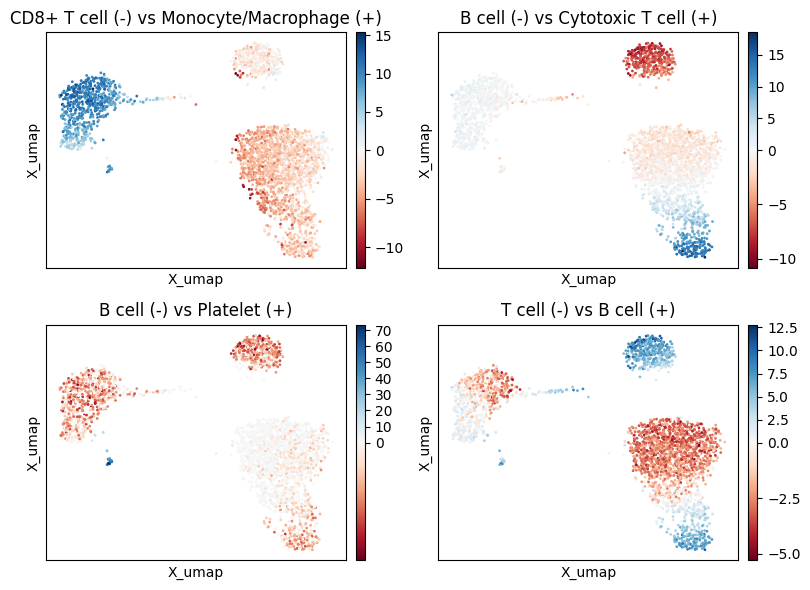

In [7]:
_ = sl.pl.factor_embedding(
    pbmc, 
    'pca', 
    factors=['0', '1', '2', '3'], 
    basis='X_umap', 
    annotation='pca_annotation',
    ncols=2
    )
plt.tight_layout()

Of course we can also query biological processes instead of cell types.

In [8]:
sl.tl.annotate_factor(
    pbmc, 
    'PCs', 
    llm, 
    top_genes=50, 
    key_added='biological_process', 
    term='biological process', 
    num_samples=10
)

(-20.0, 30.0)

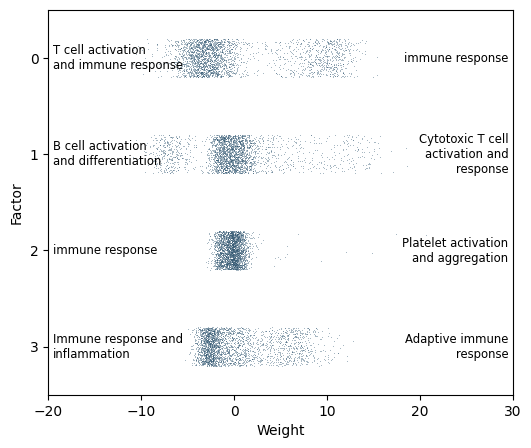

In [9]:
plt.figure(figsize=(6, 5))
ax = plt.gca()
sl.pl.factor_stripplot(
    pbmc,
    'X_pca',
    'biological_process',
    factors=['0', '1', '2', '3'],
    ax=ax,
    size=.4,
    jitter=.2
)
ax.set_xlim([-20, 30])

For NMF like factor models we can also just use the positive loading weights for the analysis.

In [10]:
sl.tl.annotate_factor(pbmc, 'PCs', llm, factors=['0', '1', '2', '3'], top_genes=40, key_added='nmf_annotation', sign='+', num_samples=2)

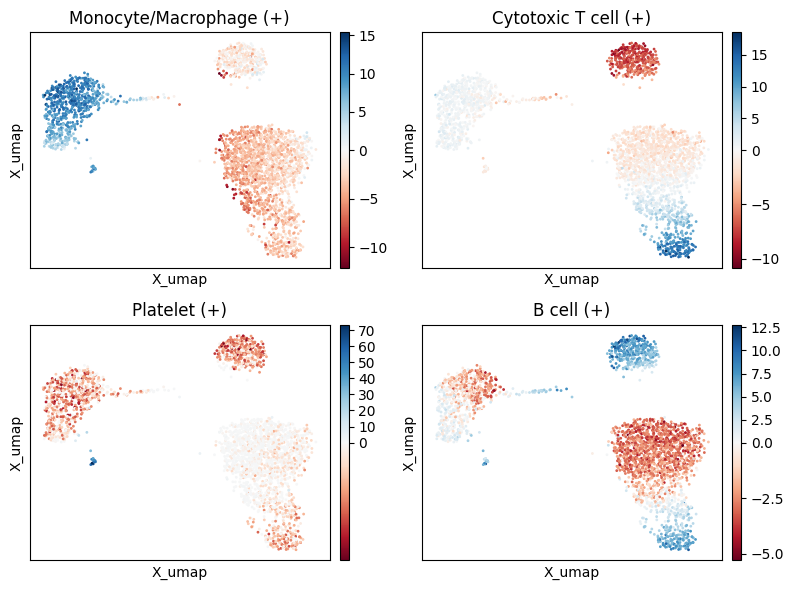

In [11]:
_ = sl.pl.factor_embedding(
    pbmc, 
    'pca', 
    factors=['0', '1', '2', '3'], 
    basis='X_umap', 
    annotation='nmf_annotation',
    ncols=2
    )
plt.tight_layout()

## Angelidis

In this example we will use the `annotate_cluster` function to annotate the cells in the Angelidis dataset.

In [12]:
angelidis = sc.read_h5ad('/Users/harald/Downloads/umap_1.h5ad')

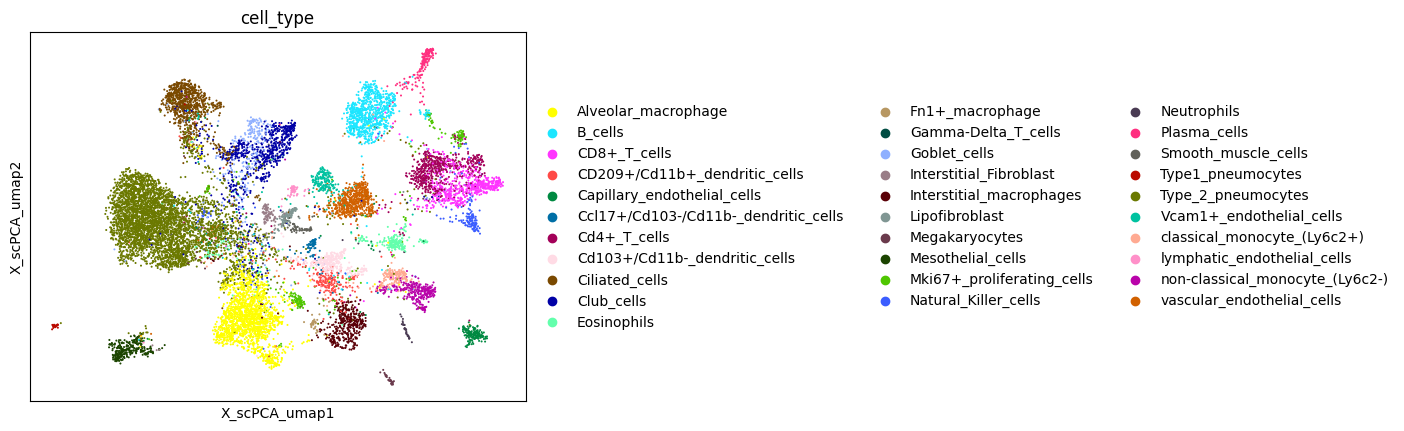

In [13]:
sc.pl.embedding(angelidis, 'X_scPCA_umap', color='cell_type')

In [14]:
angelidis

AnnData object with n_obs × n_vars = 14064 × 4000
    obs: 'barcode', 'mouse_id', 'age', 'cell_type', 'cell_id', 'super'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_name', 'X_scPCA', 'celltype_column', 'condition_column', 'hvg', 'log1p', 'main_assay', 'scPCA', 'umap', 'cell_type_colors'
    obsm: 'X_scPCA', 'X_scPCA_umap'
    varm: 'V_scPCA', 'W_scPCA', 'α_scPCA', 'σ_scPCA'
    layers: 'counts', 'offset_scPCA', 'μ_scPCA'
    obsp: 'X_scPCA_connectivities', 'X_scPCA_distances'

In [15]:
angelidis.varm['W_scpca_ref'] = angelidis.varm['W_scPCA'][..., 0]

In [16]:
sl.tl.annotate_factor(
    angelidis, 
    'W_scpca_ref', 
    llm,
    factors=['0', '1', '2', '3', '4', '5', '6'], 
    top_genes=30, 
    key_added='scpca_annotation',
    num_samples=4
)

In [17]:
angelidis.uns['scpca_annotation']['mapping']

{'0+': 'Ciliated epithelial cell',
 '0-': 'Dendritic Cell',
 '1+': 'B cell',
 '1-': 'Alveolar type II cells',
 '2+': 'Club cells (Clara cells)',
 '2-': 'B cell',
 '3+': 'B cell',
 '3-': 'Endothelial cells',
 '4+': 'Macrophage',
 '4-': 'B cell',
 '5+': 'Endothelial cell',
 '5-': 'Ciliated Epithelial Cell',
 '6+': 'CD8+ T cell',
 '6-': 'Dendritic Cell'}

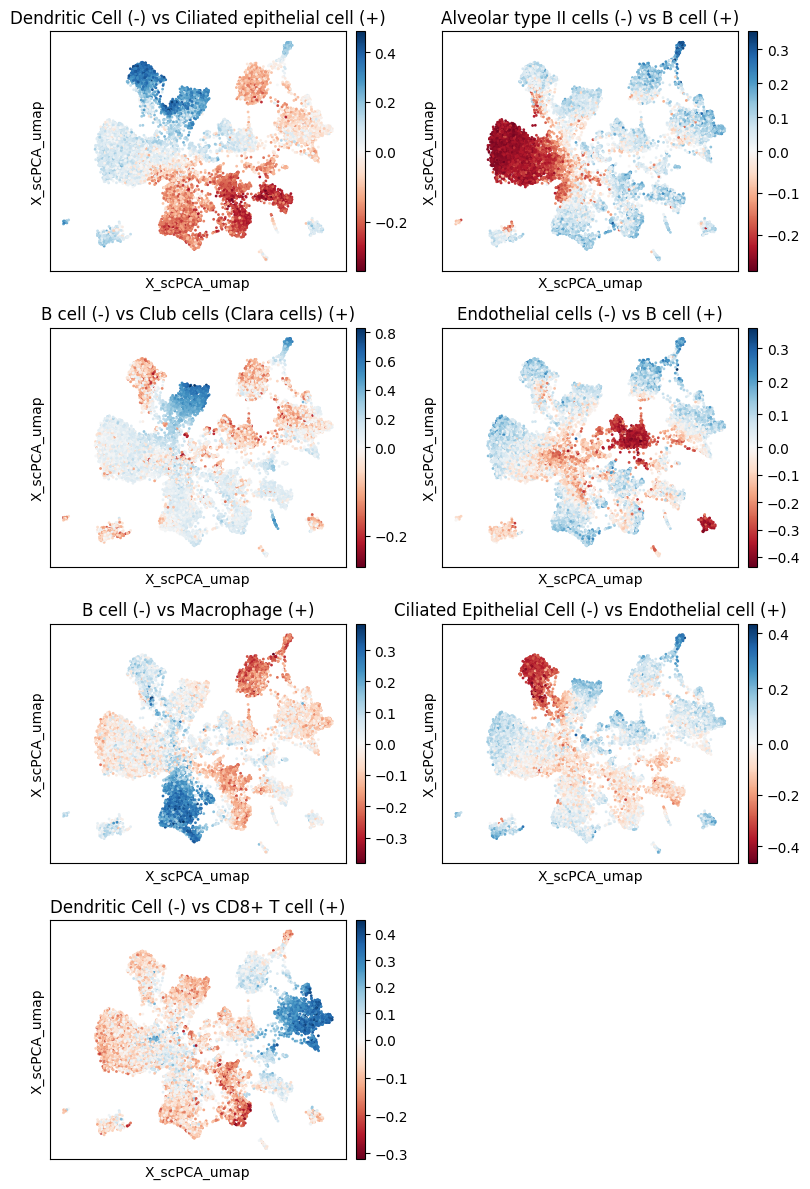

In [18]:
_ = sl.pl.factor_embedding(
    angelidis, 
    'scPCA', 
    factors=['0', '1', '2', '3', '4', '5', '6'], 
    basis='X_scPCA_umap', 
    annotation='scpca_annotation',
    ncols=2
    )
plt.tight_layout()